## **$$
\begin{cases}
  \frac{\partial}{\partial t}s(x,t) -  \frac{\partial^2 }{\partial x^2}s(x,t) = u(x) \quad \forall x,t \in [0,1] \times [0,T] \\
  s(0,t)=1 \quad \forall t \in [0,T] \\
  s(L,t)=0 \quad \forall t \in [0,T] \\
  s(x,0)=s_0(x) \quad \forall x \in [0,L] \\
\end{cases}
  $$**

# Imports

In [ ]:
!pip install deepxde
!pip install scikit-optimize
!pip install pathos
import sys
sys.path.insert(1, "/gdrive/My Drive/ScML_Referat/deepxde-0.11.2")

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ScML_Referat/Heat_2

# Gaussian Random Spaces

In [3]:
import deepxde as dde
import skopt
import deepxde112 as dde112
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from scipy.interpolate import interp1d
import pandas as pd


In [24]:
L=np.pi

# Generate the GRF function space
func_space = dde.data.GRF(L, length_scale=0.1)

# Radomly generate a bunch of functions u
feature_vectors=func_space.random(9)

# Define sensors
sensors = np.linspace(0, L, num=25)
sensors = np.concatenate((sensors[:10],sensors[15:]))[:, None]  # unimportant

# Evaluate the functions u at the sensors
functions_evaluated=func_space.eval_batch(feature_vectors,sensors)

In [ ]:
functions_evaluated[0]

In [ ]:
eval_pts=np.squeeze(sensors)

# Let's plot them
fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
  for j in range(3):
    f=interp1d(eval_pts,functions_evaluated[3*i+j],"cubic")
    x=np.linspace(eval_pts[0],eval_pts[-1],200)
    axs[i,j].plot(x,f(x))
    axs[i,j].scatter(sensors,functions_evaluated[3*i+j])

# Implement CN for Heat Equation

In [33]:
from scipy.sparse import diags
from scipy.sparse import eye
from scipy.sparse.linalg import spsolve,cg


def heat_CN(L,N,T,K,c1,c2,f,u0):
    '''
     Sintax:
       [x,t,u]=heat_CN(L,N,T,K,c1,c2,fun,u0)

     Input:
        L Lengh f interval [0,L]
    	  N Number of subintervals in (0,L)
        T max time. Time interval: (0,T)
    	  K Number of subintervals in (0,T)
        c1 Function to describe Dirichlet BC in x=0
        c2 Function to describe Dirichlet BC in x=L
        f Function to describe forcing term
        u0 Function to describe IC at t=0

     Output:
       x Vector of spacial nodes
       t Vector of temporal nodes
       u Numerical solution of the problem
    '''

    # Compute discretization step both in space and time
    h = L/N
    h_2=h*h
    dt = T/K

    # Initialization vector t
    t = np.linspace(0,T,K+1)
    # Initialization vector x
    x = np.linspace(0,L,N+1)

    # Initialization of solution matrix u
    u = np.zeros((N+1,K+1))
    # Initial condition (IC)
    u[:,0] = u0(x);
    # Boundary conditions (BC)
    u[0,:] = c1(t);
    u[-1,:] = c2(t);


    # Build sparse matrix A
    a= -1 * np.ones(N-2)
    b= 2 * np.ones(N-1)
    c= -1 * np.ones(N-2)
    A = (1/h_2) * ( diags(a, -1) + diags(b, 0) + diags(c, 1) )
    I = eye(N-1);

    # Iterative loop
    for k in range(0,K):
        # Assembly rhs
        F1 = f(x[1:-1])     #F1 = f(x[1:-1],t[k]);
        F2 = f(x[1:-1])     #F2 = f(x[1:-1],t[k+1]);

        # Apply corrections to the rhs with BC
        F1[0] = F1[0]+c1(t[k])/h_2;
        F1[-1] = F1[-1]+c2(t[k])/h_2;
        F2[0] = F2[0]+c1(t[k+1])/h_2;
        F2[-1] = F2[-1]+c2(t[k+1])/h_2;

        # Solve the problem
        u[1:-1,k+1] = spsolve( (I + dt/2*A) , ((I - dt/2*A)*u[1:-1,k] + dt/2*(F1+F2)) );
    return x,t,u


In [40]:
# Let's chose some parameters and try to solve the equation
L = np.pi
c1 = lambda t: 0*t +1
c2 = lambda t: 0*t
s0 = lambda x: c2(0)+(c2(0)-c1(0))/L * (x-L)
f = lambda x: 2*np.cos(x)
N = 200;
T = 20;
K = 20;
x,timesteps,u = heat_CN(L,N,T,K,c1,c2,f,s0)

In [ ]:
# Let's plot the solution

plt.figure()
plt.xlabel("x")
plt.title("Numerical solution of u(x,t) over time")
for t in range(len(timesteps)):
  plt.plot(x,u[:,t])
plt.plot(x,np.zeros(x.shape),'-k',lw=3)


# Prepare data for training


Generate TRAIN and VALIDATION (here called TEST) samples

In [51]:
from random import randrange

def generate_samples(num_u,L,N,T,K,c1,c2,S,P):

  # Prepare structures to hold data
  X=[[],[]]
  y=[]

  # Randomly generate u
  func_space = dde.data.GRF(L, length_scale=0.2, N=400, interp="quadratic")
  u_vectors = func_space.random(num_u)

  # Choose sensors, MUST BE FIXED for every u
  sensors = np.linspace(0, L, num=S)[:]

  # To print persentage of progress
  counter=0

  for u in u_vectors:

    # Evalaute u(x) at sensors
    u_evaluated = func_space.eval_one(u,sensors)

    # Interpolate u to pass it to solver
    eval_pts=np.squeeze(sensors)
    interpolated_u = interp1d(np.linspace(0,L,400),u,"quadratic")

    # Solve PDE for each u
    x,t,sol = heat_CN(L,N,T,K,c1,c2,interpolated_u,s0)

    # Extract a random point in space-time
    for i in range(P):
      X[0].append( u_evaluated )
      random_x_index=randrange(0,N+1)
      random_t_index=randrange(0,K+1)
      X[1].append([x[random_x_index],t[random_t_index]])
      y.append([sol[random_x_index,random_t_index]])

    # Prints the progress
    counter+=1
    clear_output()
    print(str(counter/num_u*100)+"%")

  X[0]=np.array(X[0])
  X[1]=np.array(X[1])
  y=np.array(y[:])

  return (X[0],X[1]), y

In [52]:
N = 100       # Grid refinement in space
K = 100       # Grid refinement in time
S = 100       # Number of sensors
P = 1000      # Number of sampling points
num_u = 100   # Number of functions u

In [54]:
# Generate training samples
X_train, y_train = generate_samples(num_u,L,N,T,K,c1,c2,S,P)
np.savez_compressed("Data_storage/train_data.npz", X_train0=X_train[0], X_train1=X_train[1], y_train=y_train)

# Generate validation samples
X_test, y_test = generate_samples(num_u,L,N,T,K,c1,c2,S,P)
np.savez_compressed("Data_storage/test_data.npz", X_test0=X_test[0], X_test1=X_test[1], y_test=y_test)

In [55]:
d = np.load("Data_storage/train_data.npz")
X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
d = np.load("Data_storage/test_data.npz")
X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

In [ ]:
print("Training samples")
print(X_train[0].shape)
print(X_train[1].shape)
print(y_train.shape)
print("Test samples")
print(X_test[0].shape)
print(X_test[1].shape)
print(y_test.shape)

Construct object Operator Dataset

In [ ]:
data = dde112.data.OpDataSet(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
print(data)

Build the network

In [ ]:
# Hyperparameters
lr = 0.001
epochs = 10000

# Network
activation = "relu"
initializer = "Glorot normal"
dim_x = 2

net = dde112.maps.OpNN(
    [S, 100, 100],
    [dim_x, 100, 100],
    activation,
    initializer,
    use_bias=True,
    stacked=False,
)

Build the model

In [ ]:
def mean_squared_error_outlier(y_true, y_pred):
    error = np.ravel((y_true - y_pred) ** 2)
    error = np.sort(error)[: -len(error) // 1000]
    return np.mean(error)

model = dde112.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1000
)
#model.print_model()

Train the model

In [ ]:
losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])

Initializing variables...
Training model...

0         [1.82e+01]    [1.77e+01]    [1.74e+01]    
1000      [9.93e-03]    [5.13e-01]    [5.04e-01]    
2000      [4.06e-03]    [3.38e-01]    [3.30e-01]    
3000      [1.04e-02]    [2.23e-01]    [2.18e-01]    
4000      [2.69e-03]    [1.36e-01]    [1.34e-01]    
5000      [6.38e-03]    [9.01e-02]    [8.83e-02]    
6000      [1.81e-03]    [6.06e-02]    [5.96e-02]    
7000      [1.89e-03]    [4.75e-02]    [4.68e-02]    
8000      [1.44e-03]    [4.00e-02]    [3.95e-02]    
9000      [1.66e-03]    [3.57e-02]    [3.52e-02]    
10000     [1.13e-03]    [3.31e-02]    [3.26e-02]    

Best model at step 10000:
  train loss: 1.13e-03
  test loss: 3.31e-02
  test metric: [3.26e-02]

'train' took 7311.909391 s



In [ ]:
model.save("Model_storage/model",verbose=1)

Epoch 10000: saving model to Model_storage/model-10000 ...



# Parameters: 61202
Saving loss history to /gdrive/My Drive/ScML_Referat/Heat_2/loss.dat ...
Error: The network has multiple inputs, and saving such result han't been implemented.
Error: The network has multiple inputs, and plotting such result han't been implemented.


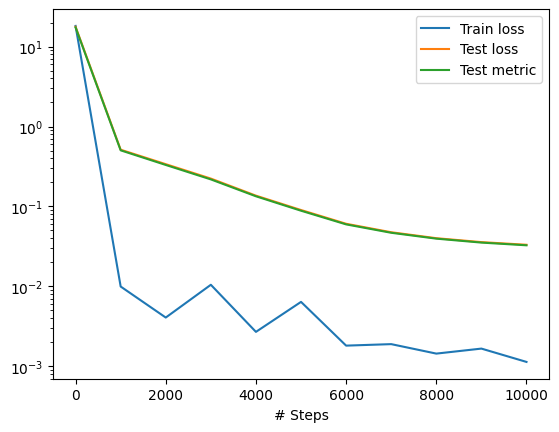

In [ ]:
print("# Parameters:", np.sum([np.prod(v.get_shape().as_list()) for v in tf.compat.v1.trainable_variables()]))
dde.saveplot(losshistory, train_state, issave=True, isplot=True)